In [98]:
import random
import string
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence


In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [100]:
allowed_chars = string.digits + '+'

class Generator:
    def __init__(self) -> None:
        pass

    def sample(self):
        s1 = random.randint(100, 99999)
        s2 = random.randint(100, 99999)
        r = s1 + s2
        input = str(str(s1) + "+" + str(s2))
        output = str(r)
        return self.string_to_tensor(input), self.string_to_tensor(output)

    def batch(self, n):
        inputs = []
        outputs = []
        for _ in range(n):
            input, output = self.sample()
            inputs.append(input)
            outputs.append(output)
        return inputs, outputs

    def string_to_tensor(self, s):
        tensor = torch.zeros(len(s), len(allowed_chars))
        for i, char in enumerate(s):
            tensor[i, allowed_chars.index(char)] = 1
        return tensor

    def tensor_to_string(self, tensor):
        _, max_idx = tensor.max(1)
        return ''.join([allowed_chars[i] for i in max_idx])

    def batch_to_tensor(self, n):
        seq_in = []
        seq_out = []
        inputs, outputs = self.batch(n)
        for input, output in zip(inputs, outputs):
            seq_in.append(input)
            seq_out.append(output)
        return pad_sequence(seq_in, batch_first=True), pad_sequence(seq_out, batch_first=True)

In [101]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden=None):
        _, (hn_enc, cn_enc) = self.encoder(input, hidden)
        latent_tensor = hn_enc[0].unsqueeze(1).repeat(1, 6, 1)
        out_dec, (_, _) = self.decoder(latent_tensor, (hn_enc, cn_enc))
        out = F.softmax(self.output(out_dec), dim=2)
        return out

model = Seq2Seq(input_size=len(allowed_chars), hidden_size=128, output_size=len(allowed_chars))
model.to(device)

Seq2Seq(
  (encoder): LSTM(11, 128, batch_first=True)
  (decoder): LSTM(128, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=11, bias=True)
)

Epoch: 0, Loss: 0.06835909932851791
Epoch: 100, Loss: 0.06848309189081192
Epoch: 200, Loss: 0.06536978483200073
Epoch: 300, Loss: 0.06423282623291016
Epoch: 400, Loss: 0.06173517554998398
Epoch: 500, Loss: 0.06248990073800087
Epoch: 600, Loss: 0.06250086426734924
Epoch: 700, Loss: 0.06148407980799675
Epoch: 800, Loss: 0.05994123965501785
Epoch: 900, Loss: 0.059828948229551315
Epoch: 1000, Loss: 0.058832090348005295
Epoch: 1100, Loss: 0.058497942984104156
Epoch: 1200, Loss: 0.05813479423522949
Epoch: 1300, Loss: 0.05859784036874771
Epoch: 1400, Loss: 0.05666862800717354
Epoch: 1500, Loss: 0.06095545366406441
Epoch: 1600, Loss: 0.06086646020412445
Epoch: 1700, Loss: 0.059238333255052567
Epoch: 1800, Loss: 0.05576479062438011
Epoch: 1900, Loss: 0.05596907064318657
Epoch: 2000, Loss: 0.05690062418580055
Epoch: 2100, Loss: 0.05648111179471016
Epoch: 2200, Loss: 0.055036760866642
Epoch: 2300, Loss: 0.05605468899011612
Epoch: 2400, Loss: 0.0563255175948143
Epoch: 2500, Loss: 0.055205460637807

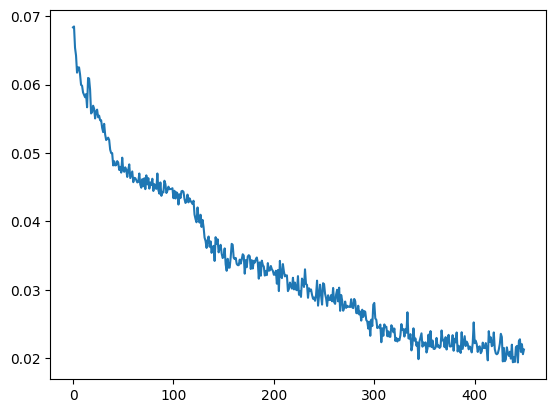

In [103]:
history = []

def train(model, optimizer, loss_fn, n_epochs, batch_size):
    for epoch in range(n_epochs):
        total_loss = 0

        optimizer.zero_grad()
        x, y = dg.batch_to_tensor(batch_size)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Print the loss every 10 epochs
        if epoch % 100 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, total_loss))
            history.append(total_loss)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

dg = Generator()
train(model, optimizer, loss_fn, 45_000, 128)
plt.plot(history, label='loss')

In [104]:
def evaluate(model, n):
    x, y = dg.batch_to_tensor(n)
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    for i in range(n):
        print(dg.tensor_to_string(x[i]), dg.tensor_to_string(y_pred[i]), dg.tensor_to_string(y[i]))

evaluate(model, 10)

65806+50792 116596 116598
30815+46333 771406 771480
32738+47488 802272 802260
21173+65723 868960 868960
96040+23314 119350 119354
14084+59229 733161 733130
55719+60530 116256 116249
79690+51584 131270 131274
47537+94346 141882 141883
51860+90895 142750 142755
